In [1]:
import numpy as np
import astropy as ap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math as m
import argparse
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.models import custom_model
from matplotlib.backends.backend_pdf import PdfPages
import scipy as sp
import uncertainties as unc
import uncertainties
from uncertainties import unumpy as unp
import kcorrect
import kcorrect.utils as ut
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import matplotlib as mp
import os

# Constants and Defining Models/Functions

Define cosmology, the slope of the luminosity function

In [8]:
cosmo=FlatLambdaCDM(H0=70.0,Om0=0.3)
fit=LevMarLSQFitter()
GAL_ALPHA=-1.1
LCBG_ALPHA=-1.0

Making Astropy Models to fit the Schechter function to data. Need to make seperate models for galaxies and LCBGs because they have different values for the faint end of the luminosity function. 

In [9]:
@custom_model
def schechter_func_gal(x,phistar=0.0056,mstar=-21):
    return (0.4*np.log(10)*phistar)*(10**(0.4*(GAL_ALPHA+1)*(mstar-x)))*(np.e**(-np.power(10,0.4*(mstar-x))))

@custom_model
def schechter_func_lcbg(x,phistar=0.0056,mstar=-21):
    return (0.4*np.log(10)*phistar)*(10**(0.4*(LCBG_ALPHA+1)*(mstar-x)))*(np.e**(-np.power(10,0.4*(mstar-x))))

Making scipy models to fit the Schechter function to data. Need to make seperate models for galaxies and LCBGs because they have different values for the faint end of the luminosity function. 

In [10]:
def schechter_func_scipy_gal(x,phistar,mstar):
    return (0.4*np.log(10)*phistar)*(10**(0.4*(GAL_ALPHA+1)*(mstar-x)))*(np.e**(-np.power(10,0.4*(mstar-x))))

def schechter_func_scipy_lcbg(x,phistar,mstar):
    return (0.4*np.log(10)*phistar)*(10**(0.4*(LCBG_ALPHA+1)*(mstar-x)))*(np.e**(-np.power(10,0.4*(mstar-x))))

Function to use astropy to fit a model to the data (again separate galaxy and lcbg functions). Astropy returns a function that can be used to plot the model against the data. This is useful for visualization.

In [11]:
def ap_fitting_gal(DATAFRAME,MASK=None):
    if MASK is None:
        MASK=[]
    #******CREATE MASK ARRAY******
    NUMBDENS=np.ma.array(np.array(DATAFRAME['Number_Density']),mask=False)
    MBINAVE=np.ma.array(np.array(DATAFRAME['Average_Absolute_Magnitude']),mask=False)
    NUMBDENSERR=np.ma.array(np.array(DATAFRAME['Number_Density_Error']),mask=False)
    #******MASK ZEROS******
    NUMBDENS.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    MBINAVE.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    NUMBDENSERR.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
     #******MASK POINTS I DON'T LIKE******
    NUMBDENS.mask[MASK]=True
    MBINAVE.mask[MASK]=True
    NUMBDENSERR.mask[MASK]=True
    print(NUMBDENS.compressed())
    #******MODELLING******
    LFFIT_INIT=schechter_func_gal()
    LFFIT=fit(LFFIT_INIT,MBINAVE.compressed(),NUMBDENS.compressed(),weights=1/NUMBDENSERR.compressed())
    return LFFIT,NUMBDENS.mask

def ap_fitting_lcbg(DATAFRAME,MASK=None):
    if MASK is None:
        MASK=[]
    #******CREATE MASK ARRAY******
    NUMBDENS=np.ma.array(np.array(DATAFRAME['Number_Density']),mask=False)
    MBINAVE=np.ma.array(np.array(DATAFRAME['Average_Absolute_Magnitude']),mask=False)
    NUMBDENSERR=np.ma.array(np.array(DATAFRAME['Number_Density_Error']),mask=False)
    #******MASK ZEROS******
    NUMBDENS.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    MBINAVE.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    NUMBDENSERR.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
     #******MASK POINTS I DON'T LIKE******
    NUMBDENS.mask[MASK]=True
    MBINAVE.mask[MASK]=True
    NUMBDENSERR.mask[MASK]=True
    print(NUMBDENS.compressed())
    #******MODELLING******
    LFFIT_INIT=schechter_func_lcbg()
    LFFIT=fit(LFFIT_INIT,MBINAVE.compressed(),NUMBDENS.compressed(),weights=1/NUMBDENSERR.compressed())
    return LFFIT,NUMBDENS.mask

Function to use scipy to fit a model to the data (again separate galaxy and lcbg functions)
scipy will return the correlation matrix which can be used to more accurately estimate the errors. 

In [12]:
def sp_fitting_gal(DATAFRAME,MASK=None,INITARRAY=None):
    if MASK is None:
        MASK=[]
    if INITARRAY==None:
        INITARRAY=[0.0056,-21]
    #******CREATE MASK ARRAY******
    NUMBDENS=np.ma.array(np.array(DATAFRAME['Number_Density']),mask=False)
    MBINAVE=np.ma.array(np.array(DATAFRAME['Average_Absolute_Magnitude']),mask=False)
    NUMBDENSERR=np.ma.array(np.array(DATAFRAME['Number_Density_Error']),mask=False)
    #******MASK ZEROS******
    NUMBDENS.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    MBINAVE.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    NUMBDENSERR.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
     #******MASK POINTS I DON'T LIKE******
    NUMBDENS.mask[MASK]=True
    MBINAVE.mask[MASK]=True
    NUMBDENSERR.mask[MASK]=True
    #******MODELLING******
    LFFIT,LFCOV=sp.optimize.curve_fit(schechter_func_scipy_gal,MBINAVE.compressed(),NUMBDENS.compressed(),p0=INITARRAY,sigma=NUMBDENSERR.compressed())
    return LFFIT,LFCOV

def sp_fitting_lcbg(DATAFRAME,MASK=None,INITARRAY=None):
    if MASK is None:
        MASK=[]
    if INITARRAY==None:
        INITARRAY=[0.0056,-21]
    #******CREATE MASK ARRAY******
    NUMBDENS=np.ma.array(np.array(DATAFRAME['Number_Density']),mask=False)
    MBINAVE=np.ma.array(np.array(DATAFRAME['Average_Absolute_Magnitude']),mask=False)
    NUMBDENSERR=np.ma.array(np.array(DATAFRAME['Number_Density_Error']),mask=False)
    #******MASK ZEROS******
    NUMBDENS.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    MBINAVE.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    NUMBDENSERR.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
     #******MASK POINTS I DON'T LIKE******
    NUMBDENS.mask[MASK]=True
    MBINAVE.mask[MASK]=True
    NUMBDENSERR.mask[MASK]=True
    #******MODELLING******
    LFFIT,LFCOV=sp.optimize.curve_fit(schechter_func_scipy_lcbg,MBINAVE.compressed(),NUMBDENS.compressed(),p0=INITARRAY,sigma=NUMBDENSERR.compressed())
    return LFFIT,LFCOV

## Import data using pandas

Import LCBG data

In [13]:
LCBG_DIR='/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION/LCBGLFOUT/apmag225/zucca_z_bins/'
LCBG_LFS={}
LCBG_LFS_INDEX=[]
for file in os.listdir(LCBG_DIR):
    if file.endswith('csv'):
        print(file)
        LCBG_LFS[file.split('.csv')[0]]=pd.read_csv(LCBG_DIR+'/'+file)
        LCBG_LFS_INDEX.append(file.split('.csv')[0])

LF_10_35_LCBG.csv
LF_35_55_LCBG.csv
LF_55_75_LCBG.csv
LF_75_100_LCBG.csv
zLF_30_80.csv


Import Galaxy data

In [14]:
GAL_DIR='/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION/FULLLFOUT/apmag225/zucca_z_bins/'
GAL_LFS={}
GAL_LFS_INDEX=[]
for file in os.listdir(GAL_DIR):
    if file.endswith('csv'):
        GAL_LFS[file.split('.csv')[0]]=pd.read_csv(GAL_DIR+'/'+file)
        GAL_LFS_INDEX.append(file.split('.csv')[0])

# Fitting Data

Defining masks. These masks were selected based on the bias limit from Zucca+2009

In [15]:
LCBG_MASKS={LCBG_LFS_INDEX[0]:[0,1,2,14,15,16,17],LCBG_LFS_INDEX[1]:[0,1,2,10,11,12,13,14],LCBG_LFS_INDEX[2]:[0,1,2,8,9,10,11,12,13,14],LCBG_LFS_INDEX[3]:[0,1,7,8,9,10,11,12,13,14,15,16,17],LCBG_LFS_INDEX[4]:[0,1,12,13,14,15,16,17]}
GAL_MASKS={GAL_LFS_INDEX[0]:[0,1,2,14,15,16,17],GAL_LFS_INDEX[1]:[10,11,12,13,14],GAL_LFS_INDEX[2]:[0,1,8,9,10,11,12,13,14],GAL_LFS_INDEX[3]:[0,7,8,9,10,11,12,13,14,15,16,17],GAL_LFS_INDEX[4]:[0,1,12,13,14,15,16,17]}

Automatically fit Schechter Function to LCBGs (both using scipy and astropy fitting routine).

The loop goes through each redshift bin automatically and saves them to a dictionary. This way the models and the values can be accessed by typing in the redshift range + LCBG at the end (ex. *LCBG_FITS_AP['10_35_LCBG_ap_fit']* will give you the model for the luminosity function between 0.1 and 0.35 from astropy)

In [16]:
LCBG_FITS_AP={}
LCBG_FITS_AP_INDEX=[]
for index in LCBG_LFS_INDEX:
    LCBG_FITS_AP[index.split('LF_')[-1]+'_ap_fit']=ap_fitting_lcbg(LCBG_LFS[index],MASK=LCBG_MASKS[index])
    LCBG_FITS_AP_INDEX.append(index.split('LF_')[-1]+'_ap_fit')
LCBG_FITS_SP={}
LCBG_FITS_SP_INDEX=[]
for index in LCBG_LFS_INDEX:
    LCBG_FITS_SP[index.split('LF_')[-1]+'_sp_fit']=sp_fitting_lcbg(LCBG_LFS[index],MASK=LCBG_MASKS[index])
    LCBG_FITS_SP_INDEX.append(index.split('LF_')[-1]+'_sp_fit')

[3.88309294e-05 2.09689260e-04 4.11921946e-04 6.44976535e-04
 7.19701437e-04 9.37092577e-04 1.03893955e-03]
[2.08197684e-05 9.91660177e-05 3.05321945e-04 5.64217530e-04
 8.95283052e-04 1.25464917e-03 1.38373013e-03]
[2.76136761e-05 1.90660449e-04 5.34830678e-04 9.93091424e-04
 1.65637663e-03]
[1.04639596e-05 6.19733206e-05 2.96790527e-04 8.27359142e-04
 1.45524778e-03]
[7.59453123e-06 2.46949014e-05 1.52430076e-04 4.34269252e-04
 8.17079068e-04 1.30345264e-03 1.25943924e-03 1.35632472e-03
 1.47079447e-03]
LF_10_35_LCBG
LF_35_55_LCBG
LF_55_75_LCBG
LF_75_100_LCBG
zLF_30_80


Automatically fit Schechter Function to GALs (both using scipy and astropy fitting routine).

The loop goes through each redshift bin automatically and saves them to a dictionary. This way the models and the values can be accessed by typing in the redshift range + GAL at the end (ex. *GAL_FITS_AP['10_35_GAL_ap_fit']* will give you the model for the luminosity function between 0.1 and 0.35 from astropy)

In [19]:
i=0
GAL_FITS_AP={}
GAL_FITS_AP_INDEX=[]
z_bin_dict={}
for index in GAL_LFS_INDEX:
    GAL_FITS_AP[index.split('LF_')[-1]+'_ap_fit']=ap_fitting_gal(GAL_LFS[index],MASK=GAL_MASKS[index])
    GAL_FITS_AP_INDEX.append(index.split('LF_')[-1]+'_ap_fit')
GAL_FITS_SP={}
GAL_FITS_SP_INDEX=[]
for index in GAL_LFS_INDEX:
    GAL_FITS_SP[index.split('LF_')[-1]+'_sp_fit']=sp_fitting_gal(GAL_LFS[index],MASK=GAL_MASKS[index])
    GAL_FITS_SP_INDEX.append(index.split('LF_')[-1]+'_sp_fit')
    z_bin_dict[i]='{}$<z\le${}'.format(index.split('_')[1],index.split('_')[2])
    i=i+1

[4.35204484e-05 3.90956996e-04 1.06433704e-03 1.89980956e-03
 3.17913630e-03 4.23473684e-03 4.78368528e-03 6.16771388e-03
 6.80547699e-03 6.55525726e-03 7.75368194e-03]
[3.90196265e-06 3.07966351e-05 9.60147277e-05 3.99841976e-04
 1.04194817e-03 2.01964815e-03 2.87975770e-03 3.56893989e-03
 4.47730044e-03]
[3.49547729e-05 2.32957366e-04 6.60515844e-04 1.66001337e-03
 2.53645098e-03 3.70743764e-03]
[5.37942022e-06 5.46053990e-05 3.24140254e-04 9.58093906e-04
 1.97237802e-03 2.83414351e-03]
[3.25823790e-05 1.62859190e-04 5.41621554e-04 1.36090978e-03
 2.27913103e-03 3.33186153e-03 3.56125077e-03 4.54626722e-03
 6.11419520e-03 9.00644107e-03]


# Saving Luminosity Function Parameters to a spreadsheet 

Making dictionary to save fit values

In [22]:
LCBG_VAL_ERROR_TO_DATAFRAME={}
for index in LCBG_FITS_SP_INDEX:
    LCBG_VAL_ERROR_TO_DATAFRAME[
        index.split('_sp')[0]
    ]=[uncertainties.correlated_values(LCBG_FITS_SP[index][0],
                                       LCBG_FITS_SP[index][1])[0].nominal_value,
      uncertainties.correlated_values(LCBG_FITS_SP[index][0],
                                       LCBG_FITS_SP[index][1])[0].std_dev,
      uncertainties.correlated_values(LCBG_FITS_SP[index][0],
                                       LCBG_FITS_SP[index][1])[1].nominal_value,
      uncertainties.correlated_values(LCBG_FITS_SP[index][0],
                                       LCBG_FITS_SP[index][1])[1].std_dev]  

GAL_VAL_ERROR_TO_DATAFRAME={}
for index in GAL_FITS_SP_INDEX:
    GAL_VAL_ERROR_TO_DATAFRAME[
        index.split('_sp')[0]
    ]=[uncertainties.correlated_values(GAL_FITS_SP[index][0],
                                       GAL_FITS_SP[index][1])[0].nominal_value,
      uncertainties.correlated_values(GAL_FITS_SP[index][0],
                                       GAL_FITS_SP[index][1])[0].std_dev,
      uncertainties.correlated_values(GAL_FITS_SP[index][0],
                                       GAL_FITS_SP[index][1])[1].nominal_value,
      uncertainties.correlated_values(GAL_FITS_SP[index][0],
                                       GAL_FITS_SP[index][1])[1].std_dev]    

Making a dataframe

In [24]:
GAL_LUMFUNC_FIT_VALS_ERRS=pd.DataFrame.from_dict(GAL_VAL_ERROR_TO_DATAFRAME,
                                                 orient='index',
                                                 columns=['PHI','PHI_unc','M','M_unc'])

LCBG_LUMFUNC_FIT_VALS_ERRS=pd.DataFrame.from_dict(LCBG_VAL_ERROR_TO_DATAFRAME,
                                                 orient='index',
                                                 columns=['PHI','PHI_unc','M','M_unc'])

Saving dataframe to excel spreadsheet (can be easily opened in pandas later)

In [26]:
LCBG_LUMFUNC_FIT_VALS_ERRS.to_excel(LCBG_DIR+'LCBG_LF_FIT_VALS.xlsx')
GAL_LUMFUNC_FIT_VALS_ERRS.to_excel(GAL_DIR+'GAL_LF_FIT_VALS.xlsx')

# Plotting

Formatting for pyplot

In [30]:
plt.style.use('seaborn-whitegrid')
#plt.style.use('default')
params = {
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 13,
    'xtick.minor.visible':True,
    'xtick.minor.size':2,
    'xtick.major.size':3,
    'ytick.minor.visible':True,
    'ytick.labelsize': 13,
    'ytick.minor.size':2,
    'ytick.major.size':3,
    'text.usetex': True,
    'figure.figsize': [7, 4], # instead of 4.5, 4.5
    'grid.linestyle': ':',
    'axes.edgecolor' : '0',
    'font.family':'serif',
    'font.serif':'Computer Modern'
    }
mp.rcParams.update(params)

Plotting without grid and saving

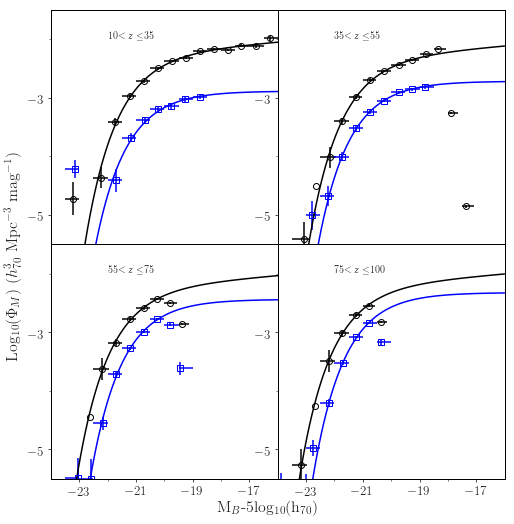

In [31]:
f=plt.figure(figsize=(7,7))
ax1=plt.subplot(2,2,1)
ax2=plt.subplot(2,2,2)
ax3=plt.subplot(2,2,3)
ax4=plt.subplot(2,2,4)

axes=[ax1,ax2,ax3,ax4]

plt.subplots_adjust(hspace=0,wspace=0)

magrange=np.linspace(-24,-16,100)
i=0

x=np.arange(-23,-15,2)
xminor=np.arange(-22,-16,2)
y=np.arange(-5,0,2)
yminor=np.arange(-4,-1,2)

for axe in axes:
    axe.set_xticks(x)
    axe.set_xticks(xminor,minor=True)
    axe.set_yticks(y)
    axe.set_yticks(yminor,minor=True)
    axe.set_ylim([-5.5,-1.5])
#    axe.set_xticklabels([])
    axe.grid(False)
    axe.set_xlim([-24,-16])
    axe.errorbar(GAL_LFS[GAL_LFS_INDEX[i]]['Average_Absolute_Magnitude'],
                 GAL_LFS[GAL_LFS_INDEX[i]]['Log10Phi'],
                 yerr=GAL_LFS[GAL_LFS_INDEX[0]]['Log10Err'],
                 xerr=[np.abs(GAL_LFS[GAL_LFS_INDEX[i]]['Average_Absolute_Magnitude']+
                              0.25-GAL_LFS[GAL_LFS_INDEX[i]]['Absolute_Magnitude_Bin']),
                       np.abs(GAL_LFS[GAL_LFS_INDEX[0]]['Average_Absolute_Magnitude']-
                              0.25-GAL_LFS[GAL_LFS_INDEX[i]]['Absolute_Magnitude_Bin'])],
                 fmt='o',label='Galaxies',color='black',fillstyle='none')
    axe.errorbar(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude'],
                 LCBG_LFS[LCBG_LFS_INDEX[i]]['Log10Phi'],
                 yerr=LCBG_LFS[LCBG_LFS_INDEX[i]]['Log10Err'],
                 xerr=[np.abs(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude']+
                              0.25-LCBG_LFS[LCBG_LFS_INDEX[i]]['Absolute_Magnitude_Bin']),
                       np.abs(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude']-
                              0.25-LCBG_LFS[LCBG_LFS_INDEX[i]]['Absolute_Magnitude_Bin'])],
                 fmt='s',label='LCBGS',color='blue',fillstyle='none')
    axe.plot(magrange,np.log10(LCBG_FITS_AP[LCBG_FITS_AP_INDEX[i]][0](magrange)),color='blue')
    axe.plot(magrange,np.log10(GAL_FITS_AP[GAL_FITS_AP_INDEX[i]][0](magrange)),color='black')
    axe.text(-22,-2,z_bin_dict[i])
    i=i+1
f.subplots_adjust(left=0.09, bottom=0.06, right=0.99, top=0.99)
f.text(0.52,0,'M$_{B}$-5log$_{10}$(h$_{70}$)',ha='center',va='center',fontsize=16)
f.text(0.02,0.5,'Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.35,'Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.55,'Log$_{10}$(N)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.15,'Log$_{10}$(N)',ha='center',va='center',rotation='vertical',fontsize=16)

plt.savefig('/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION_PLOTTING/PLOTS/PAPER/LCBG_LUMINOSITY_FUNCTION.pdf')

Plotting with grid and saving

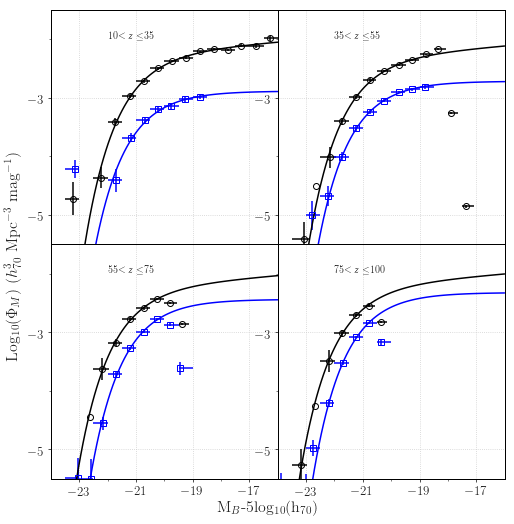

In [32]:
f=plt.figure(figsize=(7,7))
ax1=plt.subplot(2,2,1)
ax2=plt.subplot(2,2,2)
ax3=plt.subplot(2,2,3)
ax4=plt.subplot(2,2,4)

axes=[ax1,ax2,ax3,ax4]

plt.subplots_adjust(hspace=0,wspace=0)

magrange=np.linspace(-24,-16,100)
i=0

x=np.arange(-23,-15,2)
xminor=np.arange(-22,-16,2)
y=np.arange(-5,0,2)
yminor=np.arange(-4,-1,2)

for axe in axes:
    axe.set_xticks(x)
    axe.set_xticks(xminor,minor=True)
    axe.set_yticks(y)
    axe.set_yticks(yminor,minor=True)
    axe.set_ylim([-5.5,-1.5])
#    axe.set_xticklabels([])
    axe.grid(True)
    axe.set_xlim([-24,-16])
    axe.errorbar(GAL_LFS[GAL_LFS_INDEX[i]]['Average_Absolute_Magnitude'],
                 GAL_LFS[GAL_LFS_INDEX[i]]['Log10Phi'],
                 yerr=GAL_LFS[GAL_LFS_INDEX[0]]['Log10Err'],
                 xerr=[np.abs(GAL_LFS[GAL_LFS_INDEX[i]]['Average_Absolute_Magnitude']+
                              0.25-GAL_LFS[GAL_LFS_INDEX[i]]['Absolute_Magnitude_Bin']),
                       np.abs(GAL_LFS[GAL_LFS_INDEX[0]]['Average_Absolute_Magnitude']-
                              0.25-GAL_LFS[GAL_LFS_INDEX[i]]['Absolute_Magnitude_Bin'])],
                 fmt='o',label='Galaxies',color='black',fillstyle='none')
    axe.errorbar(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude'],
                 LCBG_LFS[LCBG_LFS_INDEX[i]]['Log10Phi'],
                 yerr=LCBG_LFS[LCBG_LFS_INDEX[i]]['Log10Err'],
                 xerr=[np.abs(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude']+
                              0.25-LCBG_LFS[LCBG_LFS_INDEX[i]]['Absolute_Magnitude_Bin']),
                       np.abs(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude']-
                              0.25-LCBG_LFS[LCBG_LFS_INDEX[i]]['Absolute_Magnitude_Bin'])],
                 fmt='s',label='LCBGS',color='blue',fillstyle='none')
    axe.plot(magrange,np.log10(LCBG_FITS_AP[LCBG_FITS_AP_INDEX[i]][0](magrange)),color='blue')
    axe.plot(magrange,np.log10(GAL_FITS_AP[GAL_FITS_AP_INDEX[i]][0](magrange)),color='black')
    axe.text(-22,-2,z_bin_dict[i])
    i=i+1
f.subplots_adjust(left=0.09, bottom=0.06, right=0.99, top=0.99)
f.text(0.52,0,'M$_{B}$-5log$_{10}$(h$_{70}$)',ha='center',va='center',fontsize=16)
f.text(0.02,0.5,'Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.35,'Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.55,'Log$_{10}$(N)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.15,'Log$_{10}$(N)',ha='center',va='center',rotation='vertical',fontsize=16)

plt.savefig('/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION_PLOTTING/PLOTS/PAPER/LCBG_LUMINOSITY_FUNCTION_GRID.pdf')